  VendorName ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP  ERP
0    adviser     32/60   125   256   6000   256     16    128  198  199
1     amdahl    470v/7    29  8000  32000    32      8     32  269  253
2     amdahl   470v/7a    29  8000  32000    32      8     32  220  253
3     amdahl   470v/7b    29  8000  32000    32      8     32  172  253
4     amdahl   470v/7c    29  8000  16000    32      8     16  132  132
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 no

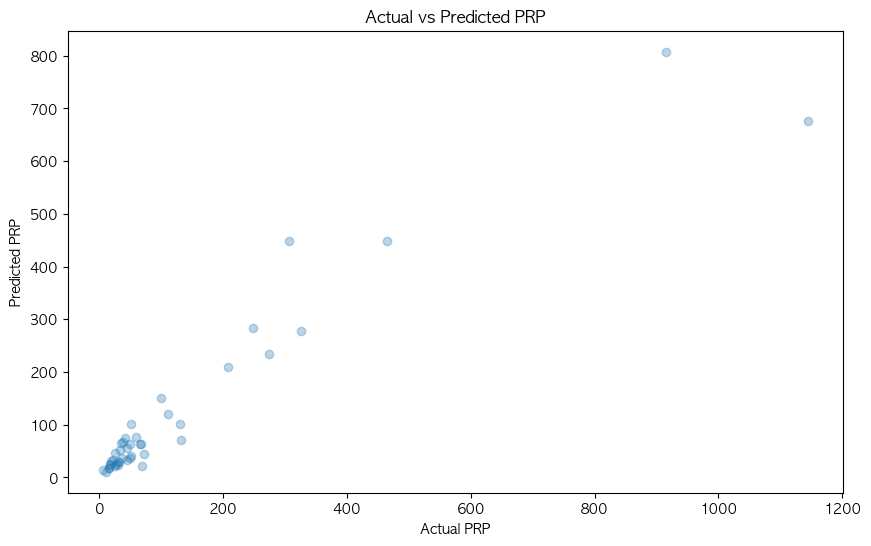

/var/folders/dk/trh511c17sqdyx33s8spg9zc0000gn/T/ipykernel_84997/3073529870.py:166: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/Users/johyeon-u/python_basic/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


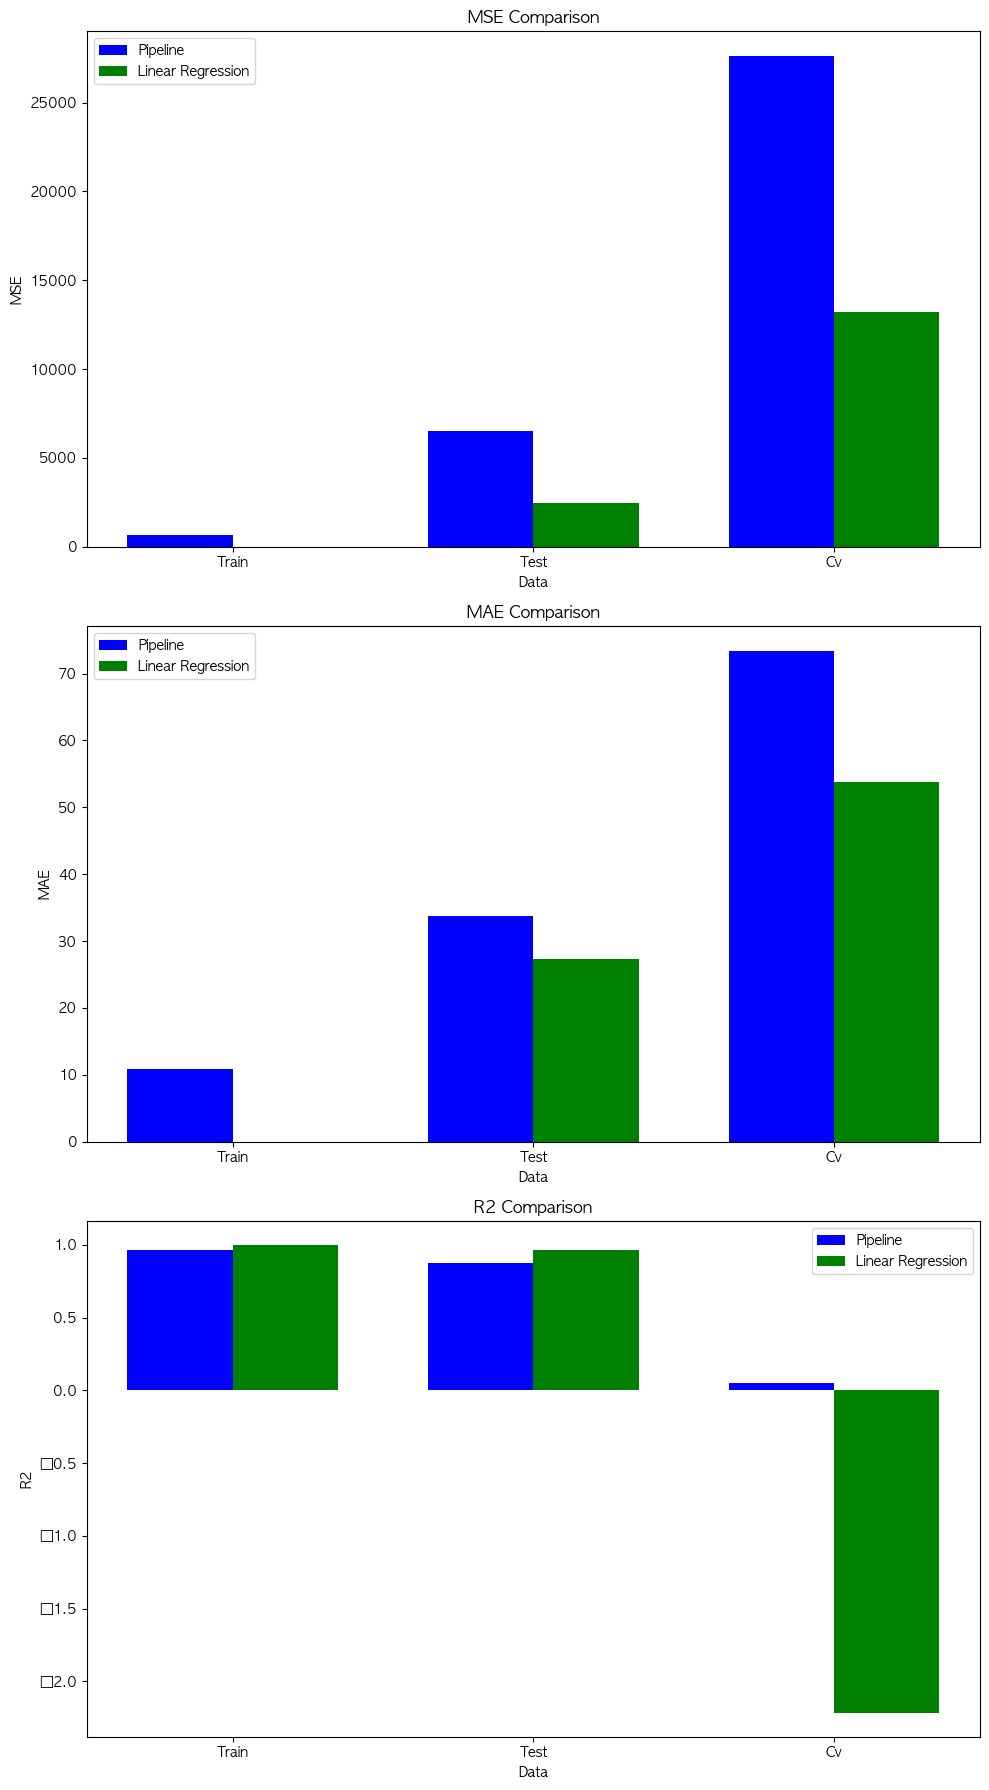

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# 데이터 로드
data = pd.read_csv('machine.data_update.csv') 

# 데이터 살펴보기
print(data.head())
print(data.info())
print(data.describe())

# 특성과 타겟 변수 분리
X = data.drop('PRP', axis=1)
y = data['PRP']

# 수치형 및 범주형 변수 구분
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# 전처리 파이프라인 구성
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 정의
model = RandomForestRegressor(random_state=42)

# 파이프라인 구성
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# 하이퍼파라미터 그리드 설정
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30]
}

# GridSearchCV를 이용한 하이퍼파라미터 튜닝
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 파라미터 출력
print("Best parameters found: ", grid_search.best_params_)

# 최적의 모델로 학습
best_model = grid_search.best_estimator_

from sklearn.metrics import mean_absolute_error

# 학습 데이터 예측
y_train_pred = best_model.predict(X_train)

# 학습 데이터 성능 평가
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f'Train MSE: {train_mse}')
print(f'Train MAE: {train_mae}')
print(f'Train R2: {train_r2}')

# 테스트 데이터 예측
y_test_pred = best_model.predict(X_test)

# 테스트 데이터 성능 평가
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test MSE: {test_mse}')
print(f'Test MAE: {test_mae}')
print(f'Test R2: {test_r2}')

# 학습 데이터에 대한 교차 검증 점수 확인
cv_train_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_train_mse = -cv_train_scores.mean()
cv_train_mae = -cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
cv_train_r2 = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2').mean()

print(f'Cross-validation Train MSE: {cv_train_mse}')
print(f'Cross-validation Train MAE: {cv_train_mae}')
print(f'Cross-validation Train R²: {cv_train_r2}')

# 테스트 데이터에 대한 교차 검증 점수 확인
cv_test_scores = cross_val_score(best_model, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
cv_test_mse = -cv_test_scores.mean()
cv_test_mae = -cross_val_score(best_model, X_test, y_test, cv=5, scoring='neg_mean_absolute_error').mean()
cv_test_r2 = cross_val_score(best_model, X_test, y_test, cv=5, scoring='r2').mean()

print(f'Cross-validation Test MSE: {cv_test_mse}')
print(f'Cross-validation Test MAE: {cv_test_mae}')
print(f'Cross-validation Test R²: {cv_test_r2}')


# 성능 지표 데이터프레임 생성
data = {
    'Model': ['pipeline'] * 3,
    'Data': ['Train', 'Test', 'Cv'],
    'MSE': [train_mse, test_mse, cv_test_mse ],
    'MAE': [train_mae, test_mae, cv_test_mae],
    'R2': [train_r2, test_r2, cv_test_r2]
}

df_pipe = pd.DataFrame(data)

# 데이터프레임 출력
print(df_pipe)

df_linear = pd.read_csv('model_performance.csv')

print(df_linear)

# 실제 vs 예측 값 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel('Actual PRP')
plt.ylabel('Predicted PRP')
plt.title('Actual vs Predicted PRP')
plt.show()

# 막대 그래프 시각화
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))

metrics = ['MSE', 'MAE', 'R2']
colors = ['blue', 'green']

# 각 지표에 대해 Pipeline과 Linear Regression의 성능을 바 차트로 표시
for i, metric in enumerate(metrics):
    bar_width = 0.35
    index = np.arange(len(df_pipe))

    rects1 = axes[i].bar(index, df_pipe[metric], bar_width, color='blue', label='Pipeline')
    rects2 = axes[i].bar(index + bar_width, df_linear[metric], bar_width, color='green', label='Linear Regression')

    axes[i].set_xlabel('Data')
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_xticks(index + bar_width / 2)
    axes[i].set_xticklabels(df_pipe['Data'])
    axes[i].legend()

plt.tight_layout()
plt.show()

